In [1]:
from pykeen.triples import TriplesFactory

from pykeen.pipeline import pipeline
from pykeen.models import predict
import pandas as pd
import numpy as np
import statistics
from scipy.ndimage import gaussian_filter1d
import math
import sys
import torch

In [3]:
path = '../dataset/graph/'
with open(path + "ddidpi.nt") as f:
    lines = f.readlines()
    
def save_graph(path, line):
    with open(path + 'plot_ddidpi_v1.ttl', 'a') as file:
        file.write(line)

In [4]:
row = ''
for line in lines:
    s = line.split(' ')[0]
    p = line.split(' ')[1]
    o = '_'.join(line.split(' ')[2:])
#     row = row + s + '\t' + p + '\t' + o + '\n'
    save_graph('V1/', s + '\t' + p + '\t' + o)

In [2]:
# # Load Train data
def load_dataset(path, name):
    triple_data = open(path + name).read().strip()
    data = np.array([triple.split('\t') for triple in triple_data.split('\n')])
    tf_data = TriplesFactory.from_labeled_triples(triples=data)
    return tf_data, triple_data


def create_model(tf_training, tf_testing, embedding, n_epoch, path, fold):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,  # 'TransE',  #'RotatE'
        # stopper='early',
        # stopper_kwargs=dict(frequency=5, patience=2, relative_delta=0.002),
#         training_loop='sLCWA',
#         negative_sampler='bernoulli',
        negative_sampler_kwargs=dict(
        filtered=True,
        ),
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='gpu',
    )
    model = results.model
    results.save_to_directory(path + embedding + str(fold))
    return model, results


# # Predict links (Head prediction)
def predict_heads(model, prop, obj, tf_testing):  # triples_factory=results.training
    predicted_heads_df = predict.get_head_prediction_df(model, prop, obj, triples_factory=tf_testing)
    return predicted_heads_df


# Filter the prediction by the head 'treatment_drug:treatment'. We are not interested in predict another links
def filter_prediction(predicted_heads_df, constraint):
    predicted_heads_df = predicted_heads_df[predicted_heads_df.head_label.str.contains(constraint)]
    return predicted_heads_df


def filter_entity(kg, c1, c2):
    sub = kg[(kg['DB00001-P00734'].str.contains(c1)) | (kg['DB00001-P00734'].str.contains(c2))]['DB00001-P00734'].values
    obj = kg[(kg.DPI.str.contains(c1)) | (kg.DPI.str.contains(c2))].DPI.values
    entity = list(sub) + list(obj)
    entity = set(entity)
    return entity


def get_config(config_file):
    config = pd.read_csv(config_file, delimiter=";")  # 'config_G1.csv'
    models = config.model.values[0].split(',')
    epochs = config.epochs.values[0]
    k = config.k_fold.values[0]
    path = config.path.values[0]
    graph_name = config.graph_name.values[0]
    return models, epochs, k, path, graph_name


def reset_index(predicted_heads):
    predicted_heads.reset_index(inplace=True)
    predicted_heads.drop(columns=['index'], inplace=True)
    return predicted_heads


def main(*args):
#     file_name, n, th_dec_eff, th_eff = select_graph(int(args[0]))
    models, epochs, k, path, graph_name = get_config(args[0])
    # models = ['TransH','RotatE', 'TransE', 'TransD', 'HolE', 'TransR', 'ERMLP', 'QuatE', 'RESCAL', 'SE', 'UM']
    models = ['TransH']
    for m in models:
        precision = 0
        recall = 0
        f_measure = 0
        for i in range(0, k):
            tf_dataset, triple_dataset = load_dataset(path, 'plot_ddidpi_v1.ttl')
            training, testing = tf_dataset.split(random_state=1234)
            
            model, results = create_model(training, testing, m, epochs, path, i + 1)
            #model = torch.load(path + m + str(i + 1) + '/trained_model.pkl') # , map_location='cpu'

In [ ]:
main('config.csv')

In [3]:
path = 'V1/'
kg = pd.read_csv(path + 'plot_ddidpi_v1.ttl', sep='\t')
display(kg.shape, kg.head(2))

(3287075, 3)

,DB00001-P00734,type,DPI
0,DB00001-P00734,hasPubMedID,pubmed:10505536
1,DB00001-P00734,hasPubMedID,pubmed:10912644


In [4]:
import Auxiliary

# Unsupervised Learning¶
#### Save Learned Embeddings

In [5]:
m = 'TransH'  #RotatE
fold=1


# path = '../Cancer_treatment/Embeddings/KG versions/V4/Uniform/G2/'
print(path)
model = torch.load(path + m + str(fold) + '/trained_model.pkl', map_location='cpu')


#model = torch.load('G/QuatE5/trained_model.pkl', map_location='cpu') #QuatE1
entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model)

V1/


## Computing clusters of the predicted heads by the model. Visualize PCA Projection to 2D
#### Creating dataframe with the embeddings predicted entities

In [6]:
tf_dataset, triple_dataset = load_dataset(path, 'plot_ddidpi_v1.ttl')
entity = filter_entity(kg, 'Drug:DB', 'uniprot:')

# tf_dataset, triple_dataset = load_dataset(path, 'train_1.ttl')
# entity = []
df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, entity, tf_dataset)

In [11]:
df = pd.DataFrame(relation_embedding_tensor.cpu().detach().numpy())
df['target'] = list(tf_dataset.relation_to_id)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,0.317661,1.159815,0.195638,0.029279,-0.095096,-0.331411,1.288227,-0.036631,0.076744,0.772584,...,0.564287,0.047700,-0.452375,0.180865,-0.432085,-0.130321,0.616793,-0.957746,-0.464920,ex:belong_to
1,0.227802,-0.546848,0.112197,0.489238,0.150010,1.039137,-0.929514,0.113503,-0.123252,-0.044714,...,-0.359526,0.332297,0.882769,0.543681,1.261208,0.910360,0.202407,1.236703,0.530759,ex:ddiEffect
2,0.117651,1.092819,0.674393,0.118853,0.065562,-0.678530,1.247083,-0.322671,-0.211110,0.690527,...,0.715809,-0.493269,-0.805174,0.642002,-1.094211,-0.678202,0.331392,-0.422233,-0.359268,ex:hasInteraction
3,0.166159,0.946349,0.267264,0.245231,0.569883,-0.294691,1.169903,-0.068890,0.067734,0.442520,...,0.643891,-0.181143,-0.979177,-0.335331,-1.102808,-0.147625,0.294904,-0.260988,-0.164563,ex:no_belong_to
4,0.279632,-0.198452,0.187805,0.495233,0.169387,0.919322,-0.506707,0.268240,-0.037796,-0.147490,...,-0.121223,0.212554,0.669163,0.830593,1.930001,0.968985,0.290553,1.074287,0.560024,ex:object_drug
5,0.136266,0.125520,0.565501,0.462899,0.026164,1.031319,0.356743,1.189928,1.404629,0.369418,...,0.729434,1.365104,1.036416,0.060805,0.219927,0.553854,-0.028792,0.351411,0.824169,ex:part_of
6,0.369756,-0.608035,0.010558,0.446023,-0.296167,0.892520,-0.500662,0.205741,-0.019144,0.036046,...,-0.847545,0.181597,0.930432,0.758636,1.789826,0.777345,0.419880,0.673154,0.623818,ex:precipitant_drug


In [12]:
new_df = pd.concat([new_df, df])
new_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,0.006761,0.098153,0.171148,0.285459,0.194057,0.039789,0.095320,0.019870,0.024906,0.027232,...,0.094346,-0.046770,0.279070,0.281148,-0.009523,-0.004122,0.030480,0.032740,0.229973,<http://example/Drug/DB00002>
1,0.075755,0.199598,0.151693,0.272905,0.006833,0.020949,0.130212,0.073956,0.045240,0.062860,...,0.058481,0.009998,-0.036871,0.159392,0.131588,0.265063,0.071499,0.034382,-0.005329,<http://example/Drug/DB00028>
2,0.021131,0.073545,-0.048232,-0.009863,0.027391,0.247679,-0.018125,-0.195567,0.252670,0.148684,...,0.092926,-0.287409,-0.090937,0.040910,0.013754,0.161320,0.151300,0.295760,-0.132719,<http://example/Drug/DB00112>
3,0.009983,0.092434,-0.120113,0.137277,0.047620,-0.210717,0.068503,-0.176825,-0.198270,-0.094943,...,-0.212898,-0.018507,-0.044002,0.035848,0.048107,0.104489,0.077876,-0.014826,-0.195472,<http://example/Drug/DB00186>
4,0.037807,0.192868,-0.100918,-0.083464,0.044941,0.010122,0.133761,-0.239984,-0.132925,-0.059226,...,-0.075226,-0.277071,-0.091502,0.061445,0.065863,-0.042207,0.142445,0.255268,-0.145142,<http://example/Drug/DB00193>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.117651,1.092819,0.674393,0.118853,0.065562,-0.678530,1.247083,-0.322671,-0.211110,0.690527,...,0.715809,-0.493269,-0.805174,0.642002,-1.094211,-0.678202,0.331392,-0.422233,-0.359268,ex:hasInteraction
3,0.166159,0.946349,0.267264,0.245231,0.569883,-0.294691,1.169903,-0.068890,0.067734,0.442520,...,0.643891,-0.181143,-0.979177,-0.335331,-1.102808,-0.147625,0.294904,-0.260988,-0.164563,ex:no_belong_to
4,0.279632,-0.198452,0.187805,0.495233,0.169387,0.919322,-0.506707,0.268240,-0.037796,-0.147490,...,-0.121223,0.212554,0.669163,0.830593,1.930001,0.968985,0.290553,1.074287,0.560024,ex:object_drug
5,0.136266,0.125520,0.565501,0.462899,0.026164,1.031319,0.356743,1.189928,1.404629,0.369418,...,0.729434,1.365104,1.036416,0.060805,0.219927,0.553854,-0.028792,0.351411,0.824169,ex:part_of


In [7]:
drug = [s for s in entity if 'Drug:DB' in s]
protein = [s for s in entity if 'uniprot:' in s]

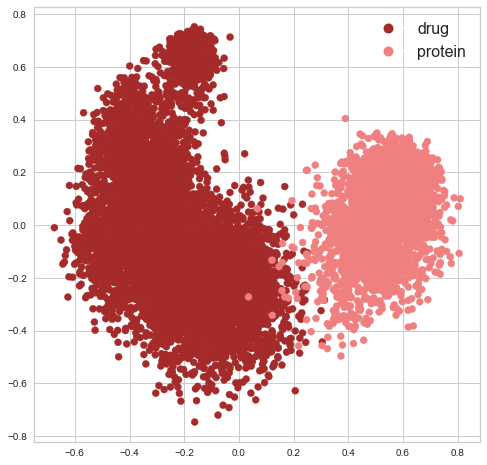

In [8]:
Auxiliary.plot_drug_protein_embedding(new_df, drug, protein)

In [13]:
new_df.to_csv('Embedding/dataset/embedding_TransH1.csv', index=None)

## Select the optimal number of clusters
#### elbow: By default, the distortion score is computed, the sum of square distances from each point to its assigned center. 

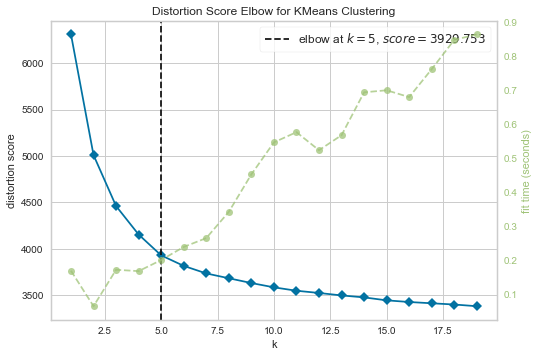

In [15]:
num_cls = Auxiliary.elbow_KMeans(df_predicted_entities, 1, 20)

## Visualize PCA Projection to 2D

C:\Users\rivasa\GitHub\Project_Scientific_DB_Programming\Auxiliary.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cluster'] = kmeans.fit_predict(new_df)
C:\Users\rivasa\GitHub\Project_Scientific_DB_Programming\Auxiliary.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['c'] = new_df.cluster.map(color_dictionary)


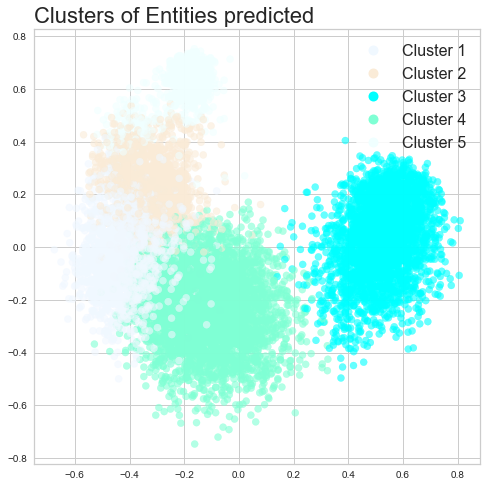

In [18]:
Auxiliary.plot_cluster(num_cls, df_predicted_entities, num_cls)